<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/prototype_model/train_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

필요한 패키지 불러오기

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install konlpy

matplotlib 한글 깨짐 해결

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

mecab 설치

In [ ]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

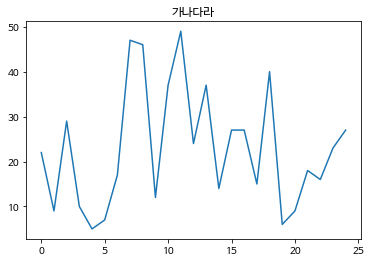

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 구글 드라이브와 코랩 연결

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/prototype_model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ls

baseline_KLUE_BERT.ipynb     bpe_10000.tmp              model/
baseline_KLUE_RoBERTa.ipynb  bpe_10000_train_spm.model  pred_data/
baseline_KoELECTRA.ipynb     bpe_10000_train_spm.vocab  train_baseline.ipynb
baseline_KoGPT.ipynb         data/
baseline_LSTM.ipynb          eval_dataset/


## 모델 클래스 및 함수 

#### 데이터 로딩 클래스

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

class DataLoad():


  def __init__(self, data_path):
    self.dataset = pd.read_csv(data_path)


  def split(self, split_size):
    X = self.dataset["pre_conversation"]
    Y = self.dataset["class"]
    print(self.dataset.groupby("class").count().iloc[:,0])
    print(self.dataset.head())
    x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = split_size, 
                                                            random_state = 200,
                                                            stratify = Y)
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
    print(f"x_train 개수 : {len(x_train)}")
    print(f"y_train 개수 : {len(y_train)}")
    print(f"x_val 개수 : {len(x_val)}")
    print(f"y_val 개수 : {len(y_val)}")
    print(f"x_test 개수 : {len(x_test)}")
    print(f"y_test 개수 : {len(y_test)}")
    print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
    print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
    print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")
    return x_train.tolist(), x_val.tolist(), x_test.tolist(), y_train.tolist(), y_val.tolist(), y_test.tolist()

#### 데이터 증강 클래스

In [6]:
import random
import gensim
from konlpy.tag import Mecab

class DataAugmentation:


  def __init__(self, word2vec_path):
    self.mecab = Mecab()
    self.word2vec = gensim.models.Word2Vec.load(word2vec_path)
  
  def sub_rep(self, X, sub_ratio = 0.1):
    # 대체 시킬 단어 무작위 선택
    nouns = list(set(self.mecab.morphs(X)))
    sub_num = int(len(nouns) * sub_ratio)
    sub_list = random.sample(nouns, sub_num)

    # 대체 시킬 단어와 유사한 단어들을 불러옴
    result = []
    for sub in sub_list:
      try:
        result.append((sub, self.word2vec.wv.most_similar(sub)[0]))
      except KeyError:
        pass
    result = list(map(lambda x: (x[0], x[1][0]), result))

    # 무작위 선택된 단어들을 유사한 단어들로 바꿔줌
    for before, after in result:
      X = X.replace(before, after, 1)
    return X

  def sub_rep_dataset(self, X, Y, sub_ratio = 0.1):
    # 입력 X에 sub_rep 함수 적용
    new_x = list(tqdm(map(lambda x: self.sub_rep(x, sub_ratio), X)))
    new_y = Y.copy()

    # 기존 데이터와 가짜 데이터를 합침
    total_x = X + new_x
    total_y = Y + new_y

    print("훈련 데이터 증강 완료")
    print(f"x_train 개수 : {len(total_x)}")
    print(f"y_train 개수 : {len(total_y)}")
    print(f"훈련 데이터 레이블 비율 확인 : {Counter(total_y)}")
    return total_x, total_y

#### Huggingface 모델 파이프라인 클래스

In [7]:
import os
import re
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


class TrainPipeline:

  def __init__(self, model_path, num_labels, batch_size = 16, epochs = 1):
    self.model_path = model_path
    self.batch_size = batch_size
    self.epochs = epochs
    self.num_labels = num_labels
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
    self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                      num_labels = self.num_labels,
                                                                      from_pt=True)

  def tf_dataset(self, X, Y, lstm = False):
    """
    모델에 들어갈 텐서플로우 데이터셋을 반환
    """
    if not lstm:
      encodings = self.tokenizer(X, truncation = True, padding = True)
      dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), 
                                                          Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size)
    else:
      encodings = X
      dataset = tf.data.Dataset.from_tensor_slices((encodings, 
                                                    Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size)
    return dataset

  def training_dataset(self, train_dataset, val_dataset):
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    self.model.compile(optimizer = optimizer,
                       loss = losses,
                       metrics = ['accuracy'])
    self.model.fit(train_dataset,
                   epochs = self.epochs,
                   batch_size = self.batch_size,
                   validation_data = val_dataset)
    return self.model

  def evaluate_model(self, x_test, lstm = False):
    predicted_label_list = []
    predicted_score_list = []

    if not lstm:
      clf_model = TextClassificationPipeline(
          tokenizer = self.tokenizer,
          model = self.model,
          framework = "tf",
          return_all_scores = True
          )
      for text in tqdm(x_test):
          # predict
          preds_list = clf_model(text)[0]
          sorted_preds_list = max(preds_list, key=lambda x: x['score'])
          predicted_label_list.append(sorted_preds_list["label"]) # label
          predicted_score_list.append(list(map(lambda x : x['score'], preds_list))) # score
      y_pred = [int(label[-1]) for label in predicted_label_list]
    else:
      predicted_score_list = model.predict(x_test)
      y_pred = np.argmax(predicted_score_list, axis = -1)
      predicted_score_list = predicted_score_list.tolist()
    return predicted_score_list, y_pred
  

  def save_model_tokenizer(self, save_path, lstm = False):
    try:
      os.mkdir(save_path)
    except:
      pass
    if not lstm:
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)    
      self.model.save_pretrained(new_path)
      self.tokenizer.save_pretrained(new_path)
    else:
      new_path = os.path.join(save_path, "LSTM.h5")
      self.model.save(new_path)

#### LSTM 모델 파이프라인 클래스

In [8]:
import os
import re
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.layers import LSTM
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import sentencepiece as spm


class LSTMpipeline(TrainPipeline):


  def __init__(self, spm_path, vocab_size, batch_size = 16, epochs = 10):
    self.tokenizer = spm.SentencePieceProcessor()
    self.tokenizer.Load(spm_path)
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.epochs = epochs

  def tokenization(self, X, Y):
    token_x_train = [self.tokenizer.EncodeAsIds(x) for x in X]
    Y = np.array(Y).reshape(-1, 1)
    return token_x_train, Y

  def padding(self, X, max_len):
    return pad_sequences(X, maxlen = max_len)
  
  def training_dataset(self, train_dataset, val_dataset, max_len):
    inputs = tf.keras.layers.Input(shape = (max_len))
    layers = tf.keras.layers.Embedding(input_dim = self.vocab_size,
                                      output_dim = 128)(inputs)

    layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)

    layers = tf.keras.layers.LSTM(128, return_sequences = True)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.LSTM(128)(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)

    layers = tf.keras.layers.Dense(128, activation = "relu")(layers)
    layers = tf.keras.layers.Dropout(0.1)(layers)
    layers = tf.keras.layers.Dense(16, activation = "relu")(layers)
    outputs = tf.keras.layers.Dense(5, activation = "softmax")(layers)

    self.model = tf.keras.Model(inputs, outputs)
    self.model.compile(optimizer="adam", 
                       loss="sparse_categorical_crossentropy", 
                       metrics=['accuracy'])

    # LSTM 모델 학습
    callback_earlystop = EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
        patience=2)
    self.model.fit(train_dataset,
                   epochs = 10,
                   batch_size = self.batch_size,
                   validation_data = val_dataset,
                   callbacks = [callback_earlystop])    
    return self.model

#### 기타 함수 

In [9]:
def id2label(x):
  if x == 0:
    return "협박 대화"
  elif x == 1:
    return "갈취 대화"
  elif x == 2:
    return "직장 내 괴롭힘 대화"
  elif x == 3:
    return "기타 괴롭힘 대화"
  elif x == 4:
    return "일반 대화"


def clf_score(y_test, y_pred):
  # classification report
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  print(f"모델이 틀린 데이터 개수 {len(false_list)}개")
  print(classification_report(y_test, y_pred))

  # confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
  conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
  sns.heatmap(conf_matrix, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("pred")
  plt.ylabel("true")
  plt.show()
  return false_list


def evaluate_result(score_list, x_test, y_pred, y_test):
  score_dataset = pd.DataFrame(score_list).add_prefix("label_")
  label_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_test":y_test})
  test_dataset = pd.concat([label_dataset, score_dataset], axis = 1)
  return test_dataset


def false_case_dataset(false_list, x_test, y_test, y_pred, print_example = False):
  false_x_test = [x_test[i] for i in false_list]
  false_y_test = [y_test[i] for i in false_list]
  false_y_pred = [y_pred[i] for i in false_list]

  false_dataset = pd.DataFrame({"text":false_x_test, "y_true":false_y_test, "y_pred":false_y_pred})
  false_dataset["y_true"] = false_dataset["y_true"].apply(lambda x : id2label(x))
  false_dataset["y_pred"] = false_dataset["y_pred"].apply(lambda x : id2label(x))

  if print_example:
    for i in range(len(false_dataset)):
      sentence, prediction, real =false_dataset.iloc[i, :]
      print(f"예측 분류 : {prediction}")
      print(f"실제 분류 : {real}")
      print(sentence)
      print("\n")
  return false_dataset  


def save_csv(df, path, name):
  try:
    os.mkdir(path)
  except:
    pass
  new_path = os.path.join(path, name)
  df.to_csv(new_path)

## Main Huggingface 함수

klue/bert-base 파이프라인 시작
class
0    896
1    896
2    896
3    896
4    896
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0        3277  ...  야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...
1        2347  ...  빨리 돈 구해와 저 정말 돈 나올데가 없어요 제발요 니네 부모님 가게 정리한 돈 어...
2        2756  ...  당신 못배워먹은거 티내지마 냅둬 못배워먹어서 고작 이딴 일이나 하는거지 죄송합니다 ...
3        2461  ...  어제까지 완료 하기로 했던 일은 다 완료 되었나요 어제 급한 일이 있어서 처리를 못...
4        3369  ...  보육원 선생님 맞으시죠 선생님 저 은희예요 저 찾을 생각하지 마세요 안 돌아갈거니까...

[5 rows x 5 columns]
x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


4032it [00:30, 132.84it/s]


훈련 데이터 증강 완료
x_train 개수 : 8064
y_train 개수 : 8064
훈련 데이터 레이블 비율 확인 : Counter({3: 1614, 4: 1614, 1: 1612, 0: 1612, 2: 1612})


Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


504/504 [==============================] - 475s 892ms/step - loss: 0.2864 - accuracy: 0.9044 - val_loss: 0.3995 - val_accuracy: 0.8795


100%|██████████| 224/224 [02:17<00:00,  1.63it/s]


모델이 틀린 데이터 개수 23개
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        45
           1       0.82      0.93      0.87        45
           2       1.00      0.82      0.90        45
           3       0.91      0.73      0.81        44
           4       1.00      1.00      1.00        45

    accuracy                           0.90       224
   macro avg       0.91      0.90      0.90       224
weighted avg       0.91      0.90      0.90       224



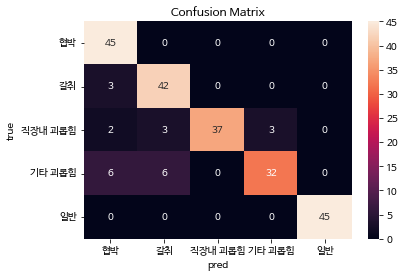

klue/bert-base 파이프라인 종료
klue/roberta-base 파이프라인 시작
class
0    896
1    896
2    896
3    896
4    896
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0        3277  ...  야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...
1        2347  ...  빨리 돈 구해와 저 정말 돈 나올데가 없어요 제발요 니네 부모님 가게 정리한 돈 어...
2        2756  ...  당신 못배워먹은거 티내지마 냅둬 못배워먹어서 고작 이딴 일이나 하는거지 죄송합니다 ...
3        2461  ...  어제까지 완료 하기로 했던 일은 다 완료 되었나요 어제 급한 일이 있어서 처리를 못...
4        3369  ...  보육원 선생님 맞으시죠 선생님 저 은희예요 저 찾을 생각하지 마세요 안 돌아갈거니까...

[5 rows x 5 columns]
x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


4032it [00:32, 124.94it/s]


훈련 데이터 증강 완료
x_train 개수 : 8064
y_train 개수 : 8064
훈련 데이터 레이블 비율 확인 : Counter({3: 1614, 4: 1614, 1: 1612, 0: 1612, 2: 1612})


Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

504/504 [==============================] - 477s 900ms/step - loss: 0.3943 - accuracy: 0.8695 - val_loss: 0.3351 - val_accuracy: 0.8973


100%|██████████| 224/224 [02:19<00:00,  1.61it/s]


모델이 틀린 데이터 개수 17개
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        45
           1       0.84      0.91      0.87        45
           2       0.96      0.98      0.97        45
           3       0.97      0.77      0.86        44
           4       1.00      0.98      0.99        45

    accuracy                           0.92       224
   macro avg       0.93      0.92      0.92       224
weighted avg       0.93      0.92      0.92       224



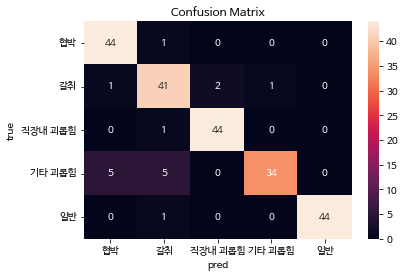

klue/roberta-base 파이프라인 종료
monologg/koelectra-base-v3-discriminator 파이프라인 시작
class
0    896
1    896
2    896
3    896
4    896
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0        3277  ...  야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...
1        2347  ...  빨리 돈 구해와 저 정말 돈 나올데가 없어요 제발요 니네 부모님 가게 정리한 돈 어...
2        2756  ...  당신 못배워먹은거 티내지마 냅둬 못배워먹어서 고작 이딴 일이나 하는거지 죄송합니다 ...
3        2461  ...  어제까지 완료 하기로 했던 일은 다 완료 되었나요 어제 급한 일이 있어서 처리를 못...
4        3369  ...  보육원 선생님 맞으시죠 선생님 저 은희예요 저 찾을 생각하지 마세요 안 돌아갈거니까...

[5 rows x 5 columns]
x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


4032it [00:32, 125.77it/s]


훈련 데이터 증강 완료
x_train 개수 : 8064
y_train 개수 : 8064
훈련 데이터 레이블 비율 확인 : Counter({3: 1614, 4: 1614, 1: 1612, 0: 1612, 2: 1612})


Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

504/504 [==============================] - 483s 910ms/step - loss: 0.4888 - accuracy: 0.8413 - val_loss: 0.2861 - val_accuracy: 0.9152


100%|██████████| 224/224 [02:07<00:00,  1.75it/s]


모델이 틀린 데이터 개수 17개
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        45
           1       0.87      0.91      0.89        45
           2       1.00      0.98      0.99        45
           3       0.92      0.75      0.83        44
           4       1.00      1.00      1.00        45

    accuracy                           0.92       224
   macro avg       0.93      0.92      0.92       224
weighted avg       0.93      0.92      0.92       224



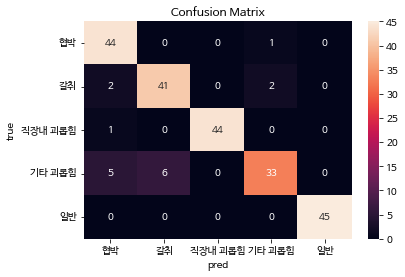

monologg/koelectra-base-v3-discriminator 파이프라인 종료


In [10]:
model_paths = ["klue/bert-base", 
               "klue/roberta-base", 
               "monologg/koelectra-base-v3-discriminator"]
# 예시 : save_path = "./model/sample"
save_path = "./model/sub_rep_2"
batch_size = 16
epochs = 1


data_path = "./data/sample_data.csv"
word2vec_path = "../packages/ko.bin"


for model_path in model_paths:
  
  print(f"{model_path} 파이프라인 시작")

  # 데이터 로딩
  load = DataLoad(data_path)
  x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)
  num_labels = int(max(y_train) + 1)

  # 데이터 증강
  data_aug = DataAugmentation(word2vec_path)
  x_train, y_train = data_aug.sub_rep_dataset(x_train, y_train)


  # 데이터셋 구축
  pipeline = TrainPipeline(model_path, num_labels, batch_size, epochs)
  train_dataset = pipeline.tf_dataset(x_train, y_train)
  val_dataset = pipeline.tf_dataset(x_val, y_val)

  # 모델 학습, 예측, 저장
  model1 = pipeline.training_dataset(train_dataset, val_dataset)
  score_list, y_pred = pipeline.evaluate_model(x_test)
  pipeline.save_model_tokenizer(save_path)

  # 모델 검증
  false_list = clf_score(y_test, y_pred)
  false_dataset = false_case_dataset(false_list, x_test, y_test, y_pred)
  eval_dataset = evaluate_result(score_list, x_test, y_pred, y_test)
  save_dataset_path = os.path.join(save_path, "eval_result")
  model_name = model_path.split("/")[-1]
  save_csv(eval_dataset, save_dataset_path, f"{model_name}.csv")
  
  print(f"{model_path} 파이프라인 종료")

## Main LSTM 함수

class
0    896
1    896
2    896
3    896
4    896
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  ...                                   pre_conversation
0        3277  ...  야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...
1        2347  ...  빨리 돈 구해와 저 정말 돈 나올데가 없어요 제발요 니네 부모님 가게 정리한 돈 어...
2        2756  ...  당신 못배워먹은거 티내지마 냅둬 못배워먹어서 고작 이딴 일이나 하는거지 죄송합니다 ...
3        2461  ...  어제까지 완료 하기로 했던 일은 다 완료 되었나요 어제 급한 일이 있어서 처리를 못...
4        3369  ...  보육원 선생님 맞으시죠 선생님 저 은희예요 저 찾을 생각하지 마세요 안 돌아갈거니까...

[5 rows x 5 columns]
x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


4032it [00:25, 159.86it/s]


훈련 데이터 증강 완료
x_train 개수 : 8064
y_train 개수 : 8064
훈련 데이터 레이블 비율 확인 : Counter({3: 1614, 4: 1614, 1: 1612, 0: 1612, 2: 1612})
Epoch 1/10
504/504 [==============================] - 46s 76ms/step - loss: 0.9233 - accuracy: 0.5645 - val_loss: 0.8494 - val_accuracy: 0.6161
Epoch 2/10
504/504 [==============================] - 37s 73ms/step - loss: 0.4767 - accuracy: 0.7850 - val_loss: 0.7905 - val_accuracy: 0.7277
Epoch 3/10
504/504 [==============================] - 37s 73ms/step - loss: 0.2203 - accuracy: 0.9245 - val_loss: 0.6555 - val_accuracy: 0.8348
Epoch 4/10
504/504 [==============================] - 37s 73ms/step - loss: 0.0675 - accuracy: 0.9824 - val_loss: 0.8494 - val_accuracy: 0.8080
Epoch 5/10
504/504 [==============================] - 37s 73ms/step - loss: 0.0370 - accuracy: 0.9918 - val_loss: 0.9759 - val_accuracy: 0.7723
모델이 틀린 데이터 개수 37개
              precision    recall  f1-score   support

           0       0.70      0.96      0.81        45
           1       0.91      0

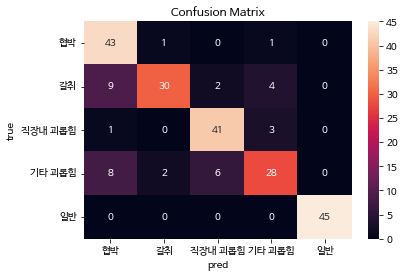

In [11]:
spm_path = "./bpe_10000_train_spm.model"
batch_size = 16
vocab_size = 10000


# 데이터 로딩
word2vec_path = "../packages/ko.bin"

load = DataLoad(data_path)
x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.1)
test_text = x_test.copy()
num_labels = int(max(y_train) + 1)

# 데이터 증강
data_aug = DataAugmentation(word2vec_path)
x_train, y_train = data_aug.sub_rep_dataset(x_train, y_train)

# 데이터셋 구축
lstmpipline = LSTMpipeline(spm_path, vocab_size, epochs = 1)
x_train, y_train = lstmpipline.tokenization(x_train, y_train)
x_val, y_val = lstmpipline.tokenization(x_val, y_val)
x_test, y_test = lstmpipline.tokenization(x_test, y_test)

max_length = max([max(map(lambda x : len(x), tmp)) for tmp in [x_train, x_val, x_test]])
x_train = lstmpipline.padding(x_train, max_length)
x_val = lstmpipline.padding(x_val, max_length)
x_test = lstmpipline.padding(x_test, max_length)

train_dataset = lstmpipline.tf_dataset(x_train, y_train, lstm = True)
val_dataset = lstmpipline.tf_dataset(x_val, y_val, lstm = True)

# LSTM 모델 학습
model = lstmpipline.training_dataset(train_dataset, val_dataset, max_length)
score_list, y_pred = lstmpipline.evaluate_model(x_test, lstm = True)
lstmpipline.save_model_tokenizer(save_path + "/LSTM", lstm = True)

# 모델 검증
false_list = clf_score(y_test, y_pred)
false_dataset = false_case_dataset(false_list, test_text, y_test, y_pred)
eval_dataset = evaluate_result(score_list, test_text, y_pred, y_test.reshape(-1))
save_dataset_path = os.path.join(save_path, "eval_result")
save_csv(eval_dataset, save_dataset_path, "LSTM.csv")

## 앙상블 Soft voting

In [12]:
import pandas as pd
from collections import defaultdict
from glob import glob

csv_dic = defaultdict()
path_list = glob(save_path + "/eval_result/*")
key_list = []
for path in path_list:
  key = path.split("/")[-1]
  key_list.append(key)
  csv_dic[key] = pd.read_csv(path)
csv_dic = dict(csv_dic)
print(f"모델명 : {key_list}")
print(f"변수명 : {list(csv_dic[key_list[0]].columns)}")
print(csv_dic[key_list[0]].head())

모델명 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'LSTM.csv']
변수명 : ['Unnamed: 0', 'x_test', 'y_pred', 'y_test', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4']
   Unnamed: 0  ...   label_4
0           0  ...  0.000869
1           1  ...  0.001428
2           2  ...  0.998992
3           3  ...  0.001241
4           4  ...  0.998662

[5 rows x 9 columns]


In [13]:
from itertools import combinations

total_case = []
for i in range(1, len(key_list)+1):
  total_case = total_case + list(combinations(key_list, i))
total_case = list(map(list, total_case))
total_case

[['bert-base.csv'],
 ['roberta-base.csv'],
 ['koelectra-base-v3-discriminator.csv'],
 ['LSTM.csv'],
 ['bert-base.csv', 'roberta-base.csv'],
 ['bert-base.csv', 'koelectra-base-v3-discriminator.csv'],
 ['bert-base.csv', 'LSTM.csv'],
 ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv'],
 ['roberta-base.csv', 'LSTM.csv'],
 ['koelectra-base-v3-discriminator.csv', 'LSTM.csv'],
 ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv'],
 ['bert-base.csv', 'roberta-base.csv', 'LSTM.csv'],
 ['bert-base.csv', 'koelectra-base-v3-discriminator.csv', 'LSTM.csv'],
 ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'LSTM.csv'],
 ['bert-base.csv',
  'roberta-base.csv',
  'koelectra-base-v3-discriminator.csv',
  'LSTM.csv']]

1번째 모델 경우의 수 : ['bert-base.csv']
모델이 틀린 데이터 개수 23개
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        45
           1       0.82      0.93      0.87        45
           2       1.00      0.82      0.90        45
           3       0.91      0.73      0.81        44
           4       1.00      1.00      1.00        45

    accuracy                           0.90       224
   macro avg       0.91      0.90      0.90       224
weighted avg       0.91      0.90      0.90       224



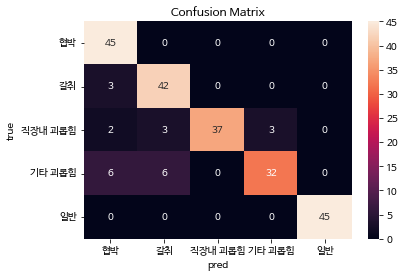

2번째 모델 경우의 수 : ['roberta-base.csv']
모델이 틀린 데이터 개수 17개
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        45
           1       0.84      0.91      0.87        45
           2       0.96      0.98      0.97        45
           3       0.97      0.77      0.86        44
           4       1.00      0.98      0.99        45

    accuracy                           0.92       224
   macro avg       0.93      0.92      0.92       224
weighted avg       0.93      0.92      0.92       224



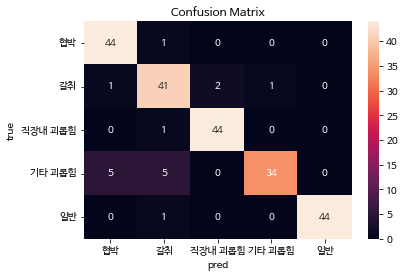

3번째 모델 경우의 수 : ['koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 17개
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        45
           1       0.87      0.91      0.89        45
           2       1.00      0.98      0.99        45
           3       0.92      0.75      0.83        44
           4       1.00      1.00      1.00        45

    accuracy                           0.92       224
   macro avg       0.93      0.92      0.92       224
weighted avg       0.93      0.92      0.92       224



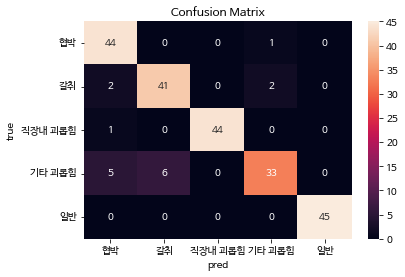

4번째 모델 경우의 수 : ['LSTM.csv']
모델이 틀린 데이터 개수 37개
              precision    recall  f1-score   support

           0       0.70      0.96      0.81        45
           1       0.91      0.67      0.77        45
           2       0.84      0.91      0.87        45
           3       0.78      0.64      0.70        44
           4       1.00      1.00      1.00        45

    accuracy                           0.83       224
   macro avg       0.85      0.83      0.83       224
weighted avg       0.85      0.83      0.83       224



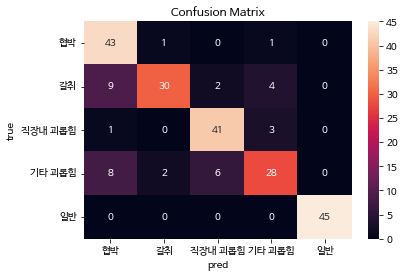

5번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv']
모델이 틀린 데이터 개수 19개
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        45
           1       0.86      0.93      0.89        45
           2       1.00      0.89      0.94        45
           3       0.94      0.75      0.84        44
           4       1.00      1.00      1.00        45

    accuracy                           0.92       224
   macro avg       0.92      0.91      0.91       224
weighted avg       0.92      0.92      0.91       224



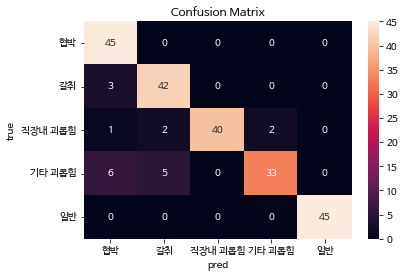

6번째 모델 경우의 수 : ['bert-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 19개
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        45
           1       0.84      0.93      0.88        45
           2       1.00      0.89      0.94        45
           3       0.94      0.75      0.84        44
           4       1.00      1.00      1.00        45

    accuracy                           0.92       224
   macro avg       0.92      0.91      0.91       224
weighted avg       0.92      0.92      0.91       224



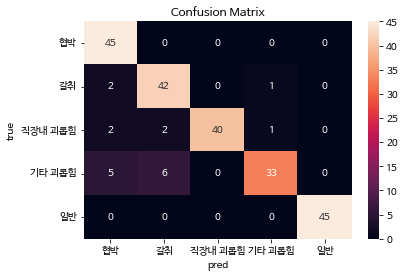

7번째 모델 경우의 수 : ['bert-base.csv', 'LSTM.csv']
모델이 틀린 데이터 개수 33개
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        45
           1       0.85      0.73      0.79        45
           2       0.87      0.91      0.89        45
           3       0.85      0.64      0.73        44
           4       1.00      1.00      1.00        45

    accuracy                           0.85       224
   macro avg       0.86      0.85      0.85       224
weighted avg       0.86      0.85      0.85       224



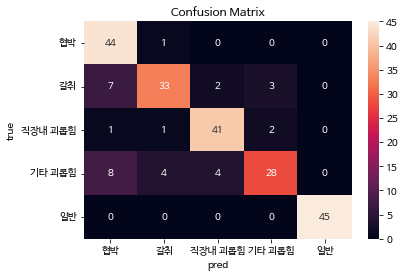

8번째 모델 경우의 수 : ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        45
           1       0.85      0.91      0.88        45
           2       1.00      0.96      0.98        45
           3       0.90      0.80      0.84        44
           4       1.00      1.00      1.00        45

    accuracy                           0.93       224
   macro avg       0.93      0.93      0.93       224
weighted avg       0.93      0.93      0.93       224



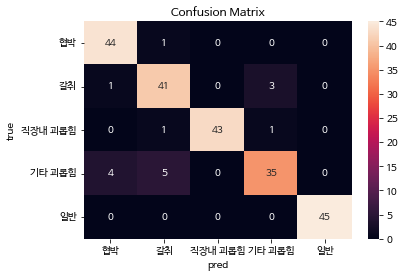

9번째 모델 경우의 수 : ['roberta-base.csv', 'LSTM.csv']
모델이 틀린 데이터 개수 34개
              precision    recall  f1-score   support

           0       0.72      0.98      0.83        45
           1       0.86      0.71      0.78        45
           2       0.87      0.91      0.89        45
           3       0.82      0.64      0.72        44
           4       1.00      1.00      1.00        45

    accuracy                           0.85       224
   macro avg       0.86      0.85      0.84       224
weighted avg       0.86      0.85      0.84       224



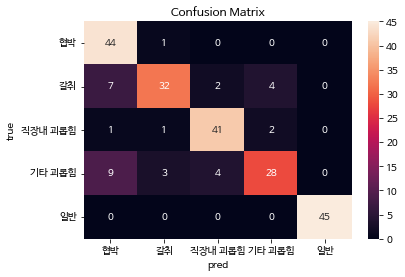

10번째 모델 경우의 수 : ['koelectra-base-v3-discriminator.csv', 'LSTM.csv']
모델이 틀린 데이터 개수 31개
              precision    recall  f1-score   support

           0       0.75      0.98      0.85        45
           1       0.89      0.69      0.78        45
           2       0.89      0.91      0.90        45
           3       0.82      0.73      0.77        44
           4       1.00      1.00      1.00        45

    accuracy                           0.86       224
   macro avg       0.87      0.86      0.86       224
weighted avg       0.87      0.86      0.86       224



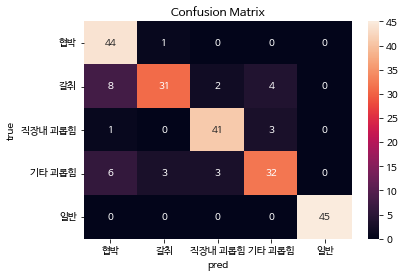

11번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        45
           1       0.88      0.93      0.90        45
           2       1.00      0.93      0.97        45
           3       0.97      0.77      0.86        44
           4       1.00      1.00      1.00        45

    accuracy                           0.93       224
   macro avg       0.94      0.93      0.93       224
weighted avg       0.94      0.93      0.93       224



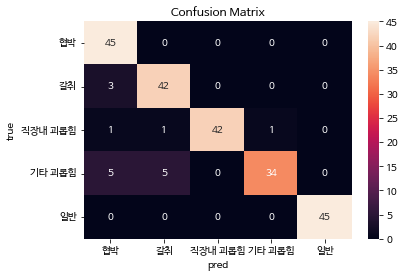

12번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'LSTM.csv']
모델이 틀린 데이터 개수 18개
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        45
           1       0.87      0.91      0.89        45
           2       0.98      0.93      0.95        45
           3       1.00      0.75      0.86        44
           4       1.00      1.00      1.00        45

    accuracy                           0.92       224
   macro avg       0.93      0.92      0.92       224
weighted avg       0.93      0.92      0.92       224



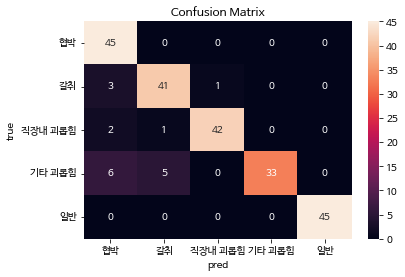

13번째 모델 경우의 수 : ['bert-base.csv', 'koelectra-base-v3-discriminator.csv', 'LSTM.csv']
모델이 틀린 데이터 개수 16개
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        45
           1       0.89      0.93      0.91        45
           2       0.98      0.93      0.95        45
           3       0.94      0.77      0.85        44
           4       1.00      1.00      1.00        45

    accuracy                           0.93       224
   macro avg       0.93      0.93      0.93       224
weighted avg       0.93      0.93      0.93       224



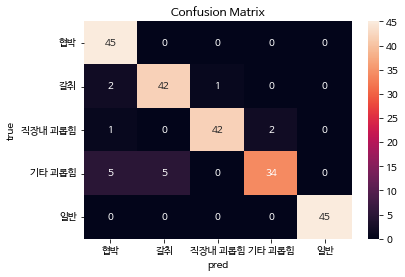

14번째 모델 경우의 수 : ['roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'LSTM.csv']
모델이 틀린 데이터 개수 15개
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        45
           1       0.89      0.91      0.90        45
           2       0.98      0.98      0.98        45
           3       0.94      0.77      0.85        44
           4       1.00      1.00      1.00        45

    accuracy                           0.93       224
   macro avg       0.94      0.93      0.93       224
weighted avg       0.94      0.93      0.93       224



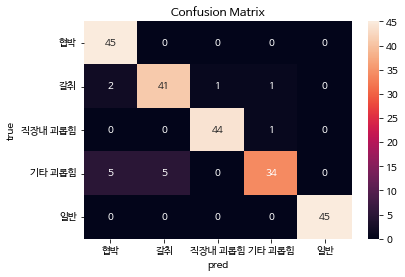

15번째 모델 경우의 수 : ['bert-base.csv', 'roberta-base.csv', 'koelectra-base-v3-discriminator.csv', 'LSTM.csv']
모델이 틀린 데이터 개수 14개
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        45
           1       0.88      0.93      0.90        45
           2       0.98      0.98      0.98        45
           3       1.00      0.77      0.87        44
           4       1.00      1.00      1.00        45

    accuracy                           0.94       224
   macro avg       0.94      0.94      0.94       224
weighted avg       0.94      0.94      0.94       224



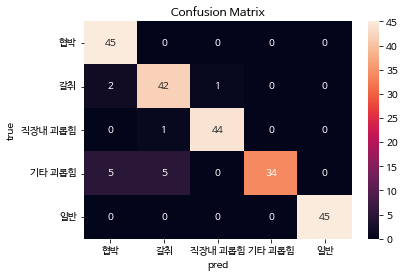

In [14]:
for idx, case in enumerate(total_case):
  print(f"{idx+1}번째 모델 경우의 수 : {case}")
  # 레이블 별 평균 점수 산출
  label_score_list = []
  for key in case:
    label_score_list.append(csv_dic[key].iloc[:,-5:].to_numpy())
  label_score_list = np.array(label_score_list)


  score_average = np.average(label_score_list, axis = 0)
  soft_voting = np.argmax(score_average, axis = -1)

  # 정답값과 예측값을 구하며 서로 맞지 않는 경우의 수도 구함
  y_pred = soft_voting.tolist()
  y_test = csv_dic[key_list[0]]["y_test"].tolist()
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  clf_score(y_test, y_pred)

  # 잘못 예측한 케이스가 담긴 데이터셋
  x_test = csv_dic[key_list[0]]["x_test"]
  false_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_true":y_test})
  false_dataset = false_dataset.iloc[false_list, :]
  false_dataset